In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install git+https://github.com/samoturk/mol2vec;

--2020-04-30 11:44:30--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-04-30 11:44:30--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   197MB/s    in 0.4s    

2020-04-30 11:44:31 (197 MB/s) - ‘Miniconda3-latest-Linux

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')


In [0]:
import numpy as np
import pandas as pd
 
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [3]:
df2 = pd.read_csv('/gdrive/My Drive/Dataset/AICrowd/Covid/22bba507-efcf-4af0-b9d0-f26193605457_train.csv')
df2.head()

,SMILES sequence,Binding Affinity
0,CCNC(C)C(NC)c1ccccc1,-18.0861
1,CONC(=O)c1cncnc1,-17.5783
2,CCNC1CCCN(Cc2ccsc2)C1,-20.3645
3,CC(NC(=O)CSCCN)c1ccccc1,-19.3144
4,CCC(CS)CN(C)c1ccccc1,-15.8451


In [0]:
df2['mol'] = df2['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x)) 
df2['mol'] = df2['mol'].apply(lambda x: Chem.AddHs(x))
df2['num_of_atoms'] = df2['mol'].apply(lambda x: x.GetNumAtoms())
df2['num_of_heavy_atoms'] = df2['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [5]:
# First we need to settle the pattern.
c_patt = Chem.MolFromSmiles('C')

# Now let's implement GetSubstructMatches() method
print(df2['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (3,), (4,), (5,), (7,), (8,), (9,), (10,), (11,), (12,), (13,))


In [0]:
#We're going to settle the function that searches patterns and use it for a list of most common atoms only
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df2)

In [10]:
#Leave only features columns
train_df = df2.drop(columns=['SMILES sequence', 'Binding Affinity', 'mol'])
y = df2['Binding Affinity'].values

print(train_df.columns)

#Perform a train-test split. We'll use 10% of the data to evaluate the model while training on 90%

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [0]:
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))

In [0]:
df2['tpsa'] = df2['mol'].apply(lambda x: Descriptors.TPSA(x))
df2['mol_w'] = df2['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df2['num_valence_electrons'] = df2['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df2['num_heteroatoms'] = df2['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [13]:
train_df = df2.drop(columns=['SMILES sequence', 'Binding Affinity', 'mol'])
y = df2['Binding Affinity'].values

print(train_df.columns)

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


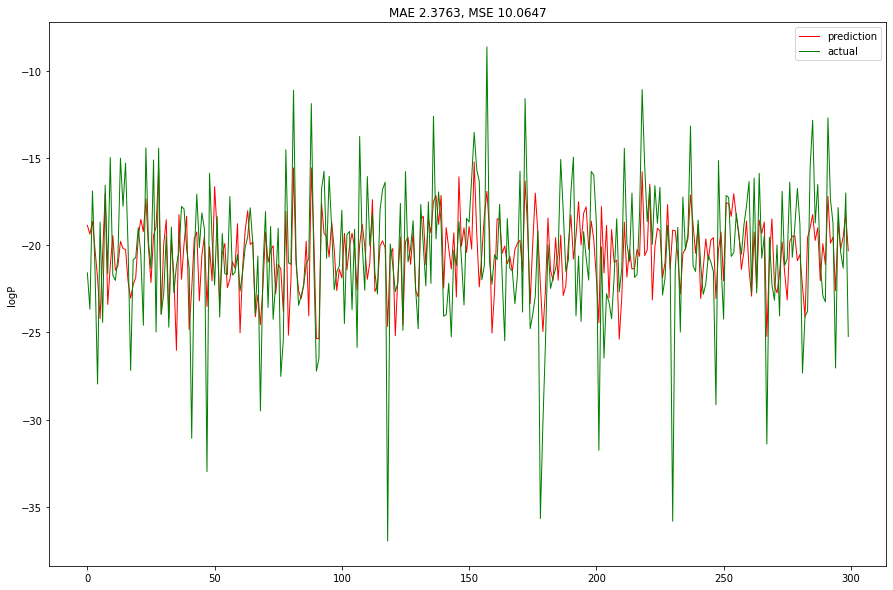

MAE score: 2.3763
MSE score: 10.0647


In [21]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

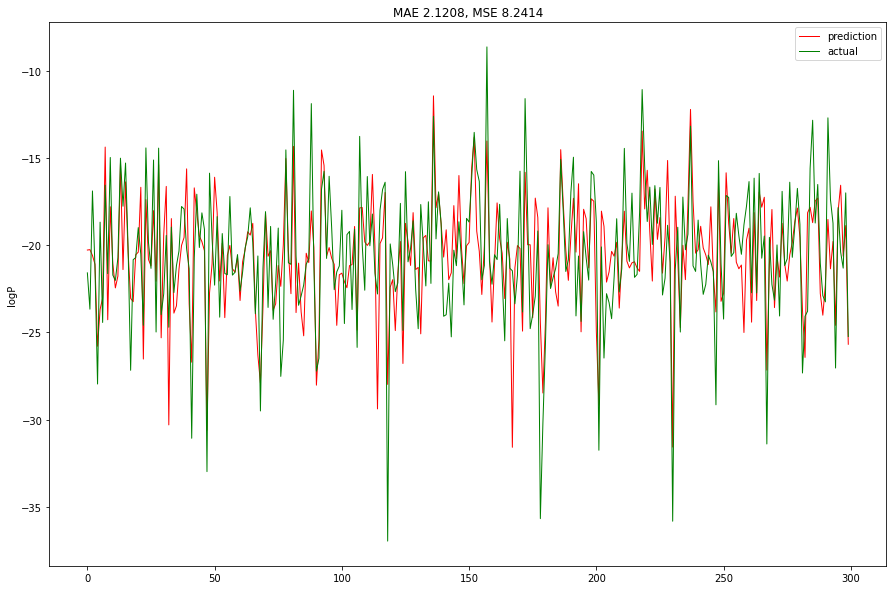

MAE score: 2.1208
MSE score: 8.2414


In [22]:
et = ExtraTreesRegressor(n_estimators=155)
  
et.fit(X_train, y_train) 
evaluation(et, X_test, y_test)

# Word2vec

In [23]:
model = word2vec.Word2Vec.load("/gdrive/My Drive/Dataset/AICrowd/Covid/model_300dim.pkl")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [24]:
df2 = pd.read_csv("/gdrive/My Drive/Dataset/AICrowd/Covid/22bba507-efcf-4af0-b9d0-f26193605457_train.csv")
print(df2.head())

target = df2['Binding Affinity']
df2.drop(columns='Binding Affinity',inplace=True)

           SMILES sequence  Binding Affinity
0     CCNC(C)C(NC)c1ccccc1          -18.0861
1         CONC(=O)c1cncnc1          -17.5783
2    CCNC1CCCN(Cc2ccsc2)C1          -20.3645
3  CC(NC(=O)CSCCN)c1ccccc1          -19.3144
4     CCC(CS)CN(C)c1ccccc1          -15.8451


In [25]:
df2['mol'] = df2['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x)) 

#Constructing sentences
df2['sentence'] = df2.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df2['mol2vec'] = [DfVec(x) for x in sentences2vec(df2['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in df2['mol2vec']])
y = target.values

print(X.shape)

(9000, 300)


In [26]:
mdf = pd.DataFrame(X)
new_df = pd.concat((mdf, train_df), axis=1)
new_df.drop(columns=["num_of_atoms", "num_of_heavy_atoms", "num_of_C_atoms", "num_of_O_atoms", "num_of_N_atoms", "num_of_Cl_atoms", "tpsa", "mol_w", "num_valence_electrons", "num_heteroatoms"], inplace=True)
print(new_df.shape)

X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=.1, random_state=1)

(9000, 300)


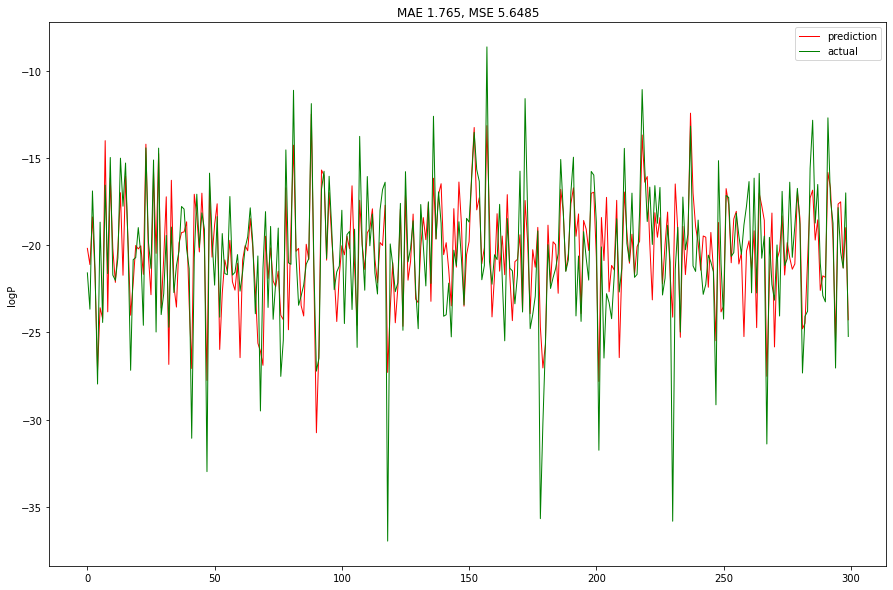

MAE score: 1.765
MSE score: 5.6485


In [27]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

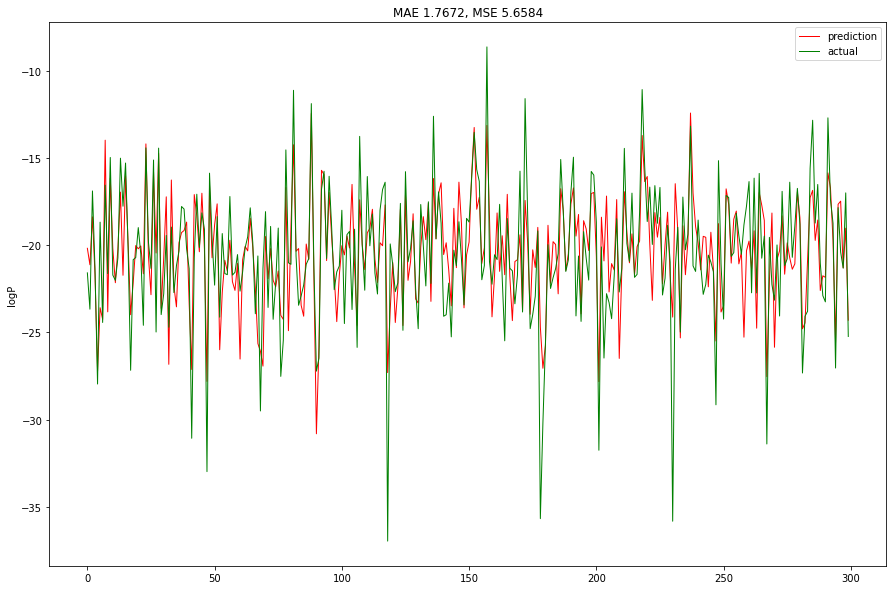

MAE score: 1.7672
MSE score: 5.6584


In [28]:
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
evaluation(regr, X_test, y_test)

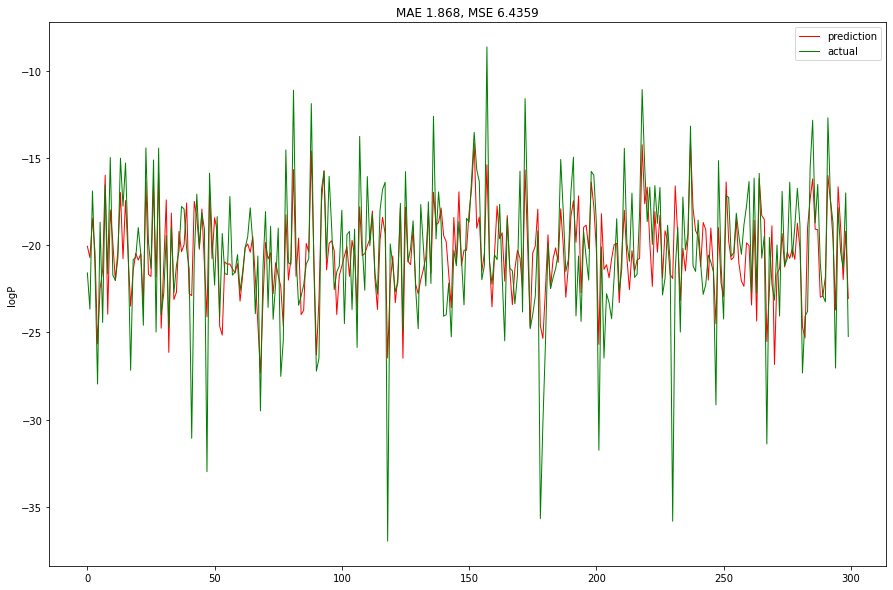

MAE score: 1.868
MSE score: 6.4359
Time taken : 61.89837956428528


In [29]:
from time import time

start_time = time()

et = ExtraTreesRegressor(n_estimators=150, n_jobs=-1)
  
et.fit(X_train, y_train) 
evaluation(et, X_test, y_test)

print("Time taken : {}".format(time() - start_time))

# Testing

In [0]:
df1 = pd.read_csv('/gdrive/My Drive/Dataset/AICrowd/Covid/4b566bb4-3155-49ff-91e1-19942504b20c_test.csv')
df1.drop(columns="Binding Affinity", inplace=True)

In [0]:
df1['mol'] = df1['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x)) 
df1['sentence'] = df1.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
df1['mol2vec'] = [DfVec(x) for x in sentences2vec(df1['sentence'], model, unseen='UNK')]

X_test = np.array([x.vec for x in df1['mol2vec']])

In [32]:
X_test.shape

(2500, 300)

In [33]:
df1["Binding Affinity"] = ridge.predict(X_test)
df1.drop(columns=["mol", "sentence", "mol2vec"], inplace=True)
df1.head()

,SMILES sequence,Binding Affinity
0,CNC(=O)N(C)c1ncccn1,-21.708088
1,O=C(Cc1ccccc1)c1ccccn1,-19.628622
2,NC1C2CCSCC12,-20.668758
3,CCC(C)C(N)(CC)c1ccccc1,-18.260963
4,N#Cc1cccc(C2OCCC2=O)n1,-18.472427


In [0]:
df1.to_csv("/gdrive/My Drive/Dataset/AICrowd/Covid/submission.csv", index=False)